In [122]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.constants import START, END
from langgraph.graph import StateGraph, MessagesState
from pydantic import BaseModel, Field
from operator import add
from trustcall import create_extractor
from typing import TypedDict, Literal
from langchain_core.runnables.config import RunnableConfig
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, RemoveMessage
from langgraph.store.base import BaseStore
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from IPython.display import Markdown, Image, display
from dotenv import dotenv_values
from pypdf import PdfReader
import pandas as pd
import os

from typing_extensions import Optional

In [123]:
env_values = {**dotenv_values(".env.shared"), **dotenv_values(".env.secret")}

os.environ["LANGSMITH_TRACING"] = env_values["LANGSMITH_TRACING"]
os.environ["LANGSMITH_ENDPOINT"] = env_values["LANGSMITH_ENDPOINT"]
os.environ["LANGSMITH_API_KEY"] = env_values["LANGSMITH_API_KEY"]
os.environ["LANGSMITH_PROJECT"] = env_values["LANGSMITH_PROJECT"]
os.environ["OPENAI_API_KEY"] = env_values["OPENAI_API_KEY"]

## Summarization graph

In [26]:
PATH_TO_FILES = "./Data"

In [27]:
def read_csv_xlsx(path: str) -> str:
    if path.endswith(".xlsx"):
        df = pd.read_excel(path)
        return df.to_string(index=False)
    else:
        df = pd.read_csv(path)
        return df.to_string(index=False)

def read_pdf(path: str) -> str:
    with open(path, "rb") as f:
        reader = PdfReader(f)
        text = ""
        for page in reader.pages:
            text += page.extractText()

    return text

def read_docs():
    dirs = os.listdir(PATH_TO_FILES)
    text = ""
    for dir in dirs:
        files = os.listdir(os.path.join(PATH_TO_FILES, dir))
        for file in files:
            if not file.endswith(".pdf"):
                text += read_csv_xlsx(os.path.join(os.path.join(PATH_TO_FILES, dir), file))
            else:
                text += read_pdf(os.path.join(os.path.join(PATH_TO_FILES, dir), file))

    return text

In [28]:
test = read_docs()

In [29]:
llm = ChatOpenAI(model="gpt-4o", temperature=0.4, top_p=0.38)

In [30]:
summarization_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a travel assistant. Help in summarizing the employee profiles, the organizational rules and the travel requirements. Ignore any IDs"),
    ("human", "Summarize this {input}")
])

In [31]:
runnable_summarization = summarization_prompt | llm

In [32]:
output = runnable_summarization.invoke({'input': test}).content

In [10]:
Markdown(output)

**Employee Profiles:**

1. **Alice Doe** - Senior Engineer
   - Travel History: USA, Germany, France (3x)
   - Preferred Airlines: Lufthansa, Delta
   - Preferred Hotels: Marriott, Hilton
   - Meal Preference: Vegetarian
   - Seat Preference: Window
   - Visa Requirement: Schengen, USA

2. **Bob Smith** - Project Manager
   - Travel History: India, UK (2x)
   - Preferred Airlines: British Airways
   - Preferred Hotels: IHG, Hyatt
   - Meal Preference: Vegan
   - Seat Preference: Aisle
   - Visa Requirement: UK, India

3. **Carol Lee** - Data Scientist
   - Travel History: Singapore, Japan (1x)
   - Preferred Airlines: Singapore Airlines
   - Preferred Hotels: Marriott
   - Meal Preference: Non-Veg
   - Seat Preference: Aisle
   - Visa Requirement: Japan, Singapore

4. **David Wong** - Cybersecurity Lead
   - Travel History: Canada, USA, Germany (4x)
   - Preferred Airlines: Air Canada, Delta
   - Preferred Hotels: Hilton
   - Meal Preference: Kosher
   - Seat Preference: Window
   - Visa Requirement: Schengen, USA, Canada

5. **Eva Patel** - Software Engineer
   - Travel History: Remote (0 trips)
   - Preferred Airlines: Emirates
   - Preferred Hotels: Hyatt
   - Meal Preference: Halal
   - Seat Preference: Window
   - Visa Requirement: Schengen

**Travel Requests:**

1. **Alice Doe** - Berlin for a Conference from 2024-07-15 to 2024-07-20, Budget: $2500, Status: Approved
2. **Bob Smith** - London for a Client Meeting from 2024-08-01 to 2024-08-05, Budget: $3000, Status: Pending
3. **Carol Lee** - Tokyo for Research from 2024-09-10 to 2024-09-20, Budget: $4500, Status: Approved
4. **David Wong** - Toronto for Internal Audit from 2024-10-05 to 2024-10-15, Budget: $3500, Status: Rejected
5. **Eva Patel** - Dubai for a Business Expo from 2024-11-01 to 2024-11-10, Budget: $2000, Status: Approved

**Organizational Rules:**

1. Max budget per trip per employee is $3,000, region dependent.
2. Business class flights are only for Director level & above.
3. Approval from direct manager is required for travel abroad.
4. Preferred airline partners are Lufthansa, Emirates, and Delta.
5. Hotels must be 4-star or higher for company bookings.
6. Travel insurance is mandatory for international trips.
7. Employees cannot book flights exceeding the budget limit.
8. Visa approval must be completed before flight booking.

### Creation of the summary graph

In [37]:
llm = ChatOpenAI(model="gpt-4o", temperature=0, top_p=0.38)

#### States

In [38]:
class SummaryGraphInput(TypedDict):
    summary: str
    text: str

class SummaryGraphOutput(TypedDict):
    summary: str


#### Utils

In [39]:
def read_csv_xlsx(path: str) -> str:
    if path.endswith(".xlsx"):
        df = pd.read_excel(path)
        return df.to_string(index=False)
    else:
        df = pd.read_csv(path)
        return df.to_string(index=False)

def read_pdf(path: str) -> str:
    with open(path, "rb") as f:
        reader = PdfReader(f)
        text = ""
        for page in reader.pages:
            text += page.extractText()

    return text

#### Prompts

In [96]:
summarization_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a travel assistant. Help in summarizing the employee profiles, the organizational rules and the travel requirements. Add the employee IDs also. Ignore any other IDs. Do not provide the output in any font or styles. Provide the summary in a neat structured format."),
    ("human", "Summarize this {input}")
])

#### Nodes

In [97]:
def read_docs(state: SummaryGraphInput):
    PATH_TO_FILES = "./Data"
    dirs = os.listdir(PATH_TO_FILES)
    text = ""
    for dir in dirs:
        files = os.listdir(os.path.join(PATH_TO_FILES, dir))
        for file in files:
            if not file.endswith(".pdf"):
                text += read_csv_xlsx(os.path.join(os.path.join(PATH_TO_FILES, dir), file))
            else:
                text += read_pdf(os.path.join(os.path.join(PATH_TO_FILES, dir), file))

    return {'text': text}

In [98]:
def summarize(state: SummaryGraphInput):
    text = state['text']
    runnable_summarization = summarization_prompt | llm
    output = runnable_summarization.invoke({'input': text}).content
    with open("./summary/summary.txt", "w") as f:
        f.write(output)
    return {'summary': output}

In [99]:
graph_summarizer_builder = StateGraph(SummaryGraphInput, output=SummaryGraphOutput)

graph_summarizer_builder.add_node("read documents", read_docs)
graph_summarizer_builder.add_node("summarize documents", summarize)

graph_summarizer_builder.add_edge(START, "read documents")
graph_summarizer_builder.add_edge("read documents", "summarize documents")
graph_summarizer_builder.add_edge("summarize documents", END)

memory = MemorySaver()
graph_summarizer = graph_summarizer_builder.compile()

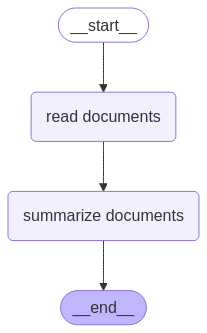

In [9]:
display(Image(graph_summarizer.get_graph().draw_mermaid_png()))

In [101]:
Markdown(graph_summarizer.invoke({}, config={'configurable': {'thread_id': "summarizer_4"}})['summary'])

Employee Profiles:
1. Employee ID: 1001
   - Name: Alice Doe
   - Role: Senior Engineer
   - Travel History: USA, Germany, France (3x)
   - Preferred Airlines: Lufthansa, Delta
   - Preferred Hotels: Marriott, Hilton
   - Meal Preference: Vegetarian
   - Seat Preference: Window
   - Visa Requirement: Schengen, USA

2. Employee ID: 1002
   - Name: Bob Smith
   - Role: Project Manager
   - Travel History: India, UK (2x)
   - Preferred Airlines: British Airways
   - Preferred Hotels: IHG, Hyatt
   - Meal Preference: Vegan
   - Seat Preference: Aisle
   - Visa Requirement: UK, India

3. Employee ID: 1003
   - Name: Carol Lee
   - Role: Data Scientist
   - Travel History: Singapore, Japan (1x)
   - Preferred Airlines: Singapore Airlines
   - Preferred Hotels: Marriott
   - Meal Preference: Non-Veg
   - Seat Preference: Aisle
   - Visa Requirement: Japan, Singapore

4. Employee ID: 1004
   - Name: David Wong
   - Role: Cybersecurity Lead
   - Travel History: Canada, USA, Germany (4x)
   - Preferred Airlines: Air Canada, Delta
   - Preferred Hotels: Hilton
   - Meal Preference: Kosher
   - Seat Preference: Window
   - Visa Requirement: Schengen, USA, Canada

5. Employee ID: 1005
   - Name: Eva Patel
   - Role: Software Engineer
   - Travel History: Remote (0 trips)
   - Preferred Airlines: Emirates
   - Preferred Hotels: Hyatt
   - Meal Preference: Halal
   - Seat Preference: Window
   - Visa Requirement: Schengen

Organizational Rules:
1. Max budget per trip per employee: $3,000 (Region dependent)
2. Business class flights only for Director level & above
3. Approval from direct manager required for travel abroad
4. Preferred airline partners: Lufthansa, Emirates, Delta
5. Hotels must be 4-star or higher for company bookings
6. Travel insurance mandatory for international trips
7. Employees cannot book flights exceeding the budget limit
8. Visa approval must be completed before flight booking

Travel Requirements:
1. Employee ID: 1001
   - Destination: Berlin
   - Purpose: Conference
   - Start Date: 2024-07-15
   - End Date: 2024-07-20
   - Budget Limit: $2500
   - Approval Status: Approved

2. Employee ID: 1002
   - Destination: London
   - Purpose: Client Meeting
   - Start Date: 2024-08-01
   - End Date: 2024-08-05
   - Budget Limit: $3000
   - Approval Status: Pending

3. Employee ID: 1003
   - Destination: Tokyo
   - Purpose: Research
   - Start Date: 2024-09-10
   - End Date: 2024-09-20
   - Budget Limit: $4500
   - Approval Status: Approved

4. Employee ID: 1004
   - Destination: Toronto
   - Purpose: Internal Audit
   - Start Date: 2024-10-05
   - End Date: 2024-10-15
   - Budget Limit: $3500
   - Approval Status: Rejected

5. Employee ID: 1005
   - Destination: Dubai
   - Purpose: Business Expo
   - Start Date: 2024-11-01
   - End Date: 2024-11-10
   - Budget Limit: $2000
   - Approval Status: Approved

## Travel Agent AI

### Creation of the graph

#### Output Formats

In [302]:
class Profile(BaseModel):
    travel_history: str = Field(description="The travel history of the employee.")
    preferences: str = Field(description="The preferences s (airlines, hotels, window/aisle, meal choice, etc.) of the employee.")
    role_specific_permissions: str = Field(description="The roles specific to this employee.")
    likes: str | None = Field(description="The likes of the employee.")
    dislikes: str | None = Field(description="The dislikes of the employee.")
    place_of_stay: str | None = Field(description="The place of stay of the employee, during the travel")

class TravelRequirements(BaseModel):
    destination: str = Field(description="The destination of travel the employee.")
    purpose: Literal['leisure', 'business'] = Field(description="The purpose of travel the employee.")
    dates: str = Field(description="The dates of travel the employee.")
    duration: str = Field(description="The duration of travel the employee.")

class OrganizationalRules(BaseModel):
    travel_budgets: str = Field(description="The travel budgets of the organization for each cadre of employee")
    approval_hierarchies: str= Field(description="The approval hierarchies for each employee.")
    preferred_vendors: str = Field(description="The preferred vendors for the organization.")
    visa_requirements: str = Field(description="The type of visa requirements for the travel.")

class Traveller(BaseModel):
    name: str = Field(description="The name of the employee.")
    employee_id: str = Field(description="The ID of the employee.")
    profile: Profile = Field(description="The profile of the employee.")
    travel_requirements: TravelRequirements = Field(description="The travel requirements for the employee.")
    organizational_rules: OrganizationalRules = Field(description="The organizational rules for the employee.")

class Travellers(BaseModel):
    travellers: list[Traveller] = Field(description="The list of travellers.")


In [303]:
from pprint import pprint

In [304]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

trustcall_extractor = create_extractor(
    llm,
    tools=[Travellers],
    tool_choice="Travellers"
)

In [305]:
with open("./summary/summary.txt", "r") as f:
    data = f.read()

In [306]:
system_msg = "Extract the profiles of all employees from the given data. {data}"
trustcaller_system_message = SystemMessage(content=system_msg.format(data=data))

In [307]:
result = trustcall_extractor.invoke({"messages": [trustcaller_system_message]})

In [308]:
schema = result['responses']

In [309]:
schema[0].model_dump()

{'travellers': [{'name': 'Alice Doe',
   'employee_id': '1001',
   'profile': {'travel_history': 'USA, Germany, France (3x)',
    'preferences': 'Preferred Airlines: Lufthansa, Delta; Preferred Hotels: Marriott, Hilton; Meal Preference: Vegetarian; Seat Preference: Window',
    'role_specific_permissions': 'Senior Engineer',
    'likes': None,
    'dislikes': None},
   'travel_requirements': {'destination': 'Berlin',
    'purpose': 'business',
    'dates': '2024-07-15 to 2024-07-20',
    'duration': '5 days'},
   'organizational_rules': {'travel_budgets': 'Max budget per trip per employee: $3,000 (Region dependent)',
    'approval_hierarchies': 'Approval from direct manager required for travel abroad',
    'preferred_vendors': 'Preferred airline partners: Lufthansa, Emirates, Delta; Hotels must be 4-star or higher for company bookings',
    'visa_requirements': 'Visa approval must be completed before flight booking'}},
  {'name': 'Bob Smith',
   'employee_id': '1002',
   'profile': {'t

In [310]:
travellers =  result["messages"][0].tool_calls[0]['args']['travellers']

In [311]:
in_mem_store = InMemoryStore()


for traveller in travellers:
    key = traveller.get("employee_id", None)
    if key is not None:
        namespace = ("memory", key.lower())
        in_mem_store.put(namespace, "traveler", traveller)


In [246]:
for traveller in travellers:
    in_mem_store.delete(namespace, traveller.get("name"))

In [248]:
for m in in_mem_store.search(("memory", "1001")):
    pprint(m)

Item(namespace=['memory', '1001'], key='traveler', value={'name': 'Alice Doe', 'employee_id': '1001', 'profile': {'travel_history': 'USA, Germany, France (3x)', 'preferences': 'Preferred Airlines: Lufthansa, Delta; Preferred Hotels: Marriott, Hilton; Meal Preference: Vegetarian; Seat Preference: Window', 'role_specific_permissions': 'Senior Engineer'}, 'travel_requirements': {'destination': 'Berlin', 'purpose': 'business', 'dates': '2024-07-15 to 2024-07-20', 'duration': '5 days'}, 'organizational_rules': {'travel_budgets': 'Max budget per trip per employee: $3,000 (Region dependent)', 'approval_hierarchies': 'Approval from direct manager required for travel abroad', 'preferred_vendors': 'Preferred airline partners: Lufthansa, Emirates, Delta; Hotels must be 4-star or higher for company bookings', 'visa_requirements': 'Visa approval must be completed before flight booking'}}, created_at='2025-03-25T16:47:15.931577+00:00', updated_at='2025-03-25T16:47:15.931579+00:00', score=None)


#### States

In [312]:
class TravelAgent(MessagesState):
    profile: Traveller
    output: str
    prompt: str
    summary: str

#### Prompts

In [313]:
travel_agent_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a travel assistant. Understand the summary {summary} and help provide responses.
    Help provide the itenary, suggest good hotels, the type of transport, the weather, the flight details, and help mark the calender also. You are essentially a travel concierge. Only respond to travel related questions.
    """),
    ("placeholder", "{history}"),
    ("human", "{prompt}")
])

#### Create Nodes

In [314]:
def read_profile(state: TravelAgent, config: RunnableConfig, store: BaseStore):
    id = config['configurable']['user_id']
    namespace = ("memory", id)
    profile = store.get(namespace, "traveler")
    state['profile'] = profile.value
    return state

In [315]:
def check_profiles(state: TravelAgent):
    profile = state['profile']
    if profile is None:
        return END
    else:
        return "chatbot"


In [368]:
summarization_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an assistant, who helps in summarizing the conversation.
    Conversation: {messages}"""),
    ("human", "Summarize the conversation")
])

In [369]:
def route_ai(state: TravelAgent):
    messages = state['messages']
    count = 0
    for message in messages:
        if isinstance(message, AIMessage) and count < 5:
            count += 1
    print(count)
    if count >= 5:
        return "summarizer and updater"
    else:
        return END

In [370]:
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation only if necessary. Do not change the organization rules. If no changes are necessary then return None"""

In [371]:
def summarizer_and_updater(state: TravelAgent, config: RunnableConfig, store: BaseStore):
    messages = state['messages']
    runnable_summarizer = summarization_prompt | llm
    extractor = create_extractor(
        llm,
        tools=[Traveller],
        tool_choice="Traveller"
    )
    summary = state.get('summary', "")
    output = runnable_summarizer.invoke({'messages': messages}).content
    summary += output
    deleted_messages = [RemoveMessage(id=message.id) for message in messages[:-4]]
    profile = state['profile']
    json_profile = {"Traveller": profile}

    result = extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)] + messages, 'existing': json_profile})
    updated_profile = result['responses'][0].model_dump()
    store.put(("memory", config['configurable']['user_id']), 'traveler', updated_profile)
    state['summary'] = summary
    state['messages'] = deleted_messages
    return state

In [372]:
chatbot_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a travel assistant. Help answer questions based on the profile. Analyze the profile and give relevant suggestions according to the profile.
    The order of precedence for suggestions is likes, dislikes and then preferences. Adhere to the organizational rules for budget and other corporate matters.
    The itinerary must be in a well structured format with the most likely to visit places first. Do not provide more than 5 suggestions. Take into account if there is any meetings when providing the time for leisure activities.
    Answer questions only related to travelling.
    Summary of the conversation (can be empty also): {summary}
    Profile: {profile}"""),
    ("human", "{input}")

])

In [373]:
def chatbot(state: TravelAgent):
    prompt = state['prompt']
    summary = state.get('summary', "")
    profile = state['profile']
    if summary is None:
        summary = state['messages']
    runnable_chatbot = chatbot_prompt | llm
    output = runnable_chatbot.invoke({'input': prompt, 'summary': summary, "profile": profile}).content
    state['output'] = output
    state['messages'] = [("ai", output)]
    return state

In [374]:
graph_chatbot_builder = StateGraph(TravelAgent)

graph_chatbot_builder.add_node("read profile", read_profile)
graph_chatbot_builder.add_node("chatbot", chatbot)
graph_chatbot_builder.add_node("summarizer and updater", summarizer_and_updater)

graph_chatbot_builder.add_edge(START, "read profile")
graph_chatbot_builder.add_conditional_edges("read profile", check_profiles, ["chatbot", END])
graph_chatbot_builder.add_conditional_edges("chatbot", route_ai, ["summarizer and updater", END])
graph_chatbot_builder.add_edge("summarizer and updater", END)

memory = MemorySaver()
store = InMemoryStore()
graph_chatbot = graph_chatbot_builder.compile(checkpointer=memory, store=in_mem_store)

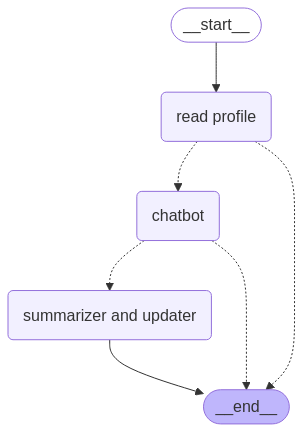

In [157]:
display(Image(graph_chatbot.get_graph().draw_mermaid_png()))

In [375]:
config = {'configurable': {'thread_id': "chatbot-new-18", "user_id": "1002"}}

In [376]:
# for _ in range(3):
user_input = input()
test = graph_chatbot.invoke({"prompt": user_input, "messages": [("human", user_input)]}, config=config)
    # print(test['output'])

1


In [377]:
print(test['output'])

Based on Bob Smith's profile and preferences, here are some restaurant suggestions in Paris that align with his likes and dietary preferences:

1. **Le Potager de Charlotte**
   - Cuisine: Vegan
   - Highlights: Known for its creative vegan dishes, this restaurant offers a delightful experience for those who prefer plant-based meals. It's a great spot to enjoy a vegan pasta dish.

2. **Gentle Gourmet**
   - Cuisine: Vegan
   - Highlights: This restaurant is famous for its gourmet vegan cuisine and offers a variety of dishes that cater to vegan preferences. It's an excellent choice for a sophisticated dining experience.

3. **Le Faitout**
   - Cuisine: Vegan
   - Highlights: A cozy spot that offers a range of vegan dishes, including pasta options. It's perfect for a casual meal while exploring the city.

4. **42 Degrés**
   - Cuisine: Raw Vegan
   - Highlights: Known for its raw vegan menu, this restaurant provides a unique dining experience with innovative dishes that are both healthy 